# Problem Set 2. Incomplete Markets

Manuel Amador

Python 3.5

You can download the anaconda python distribution from here: 

https://www.continuum.io/downloads

More details in Sargent and Stachurski Quantecon's website:

http://quant-econ.net/py/index.html

## Initial setup 

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=120)
import numba as nb
import time

## Parameters and grids

In [2]:
beta= 0.95
bigR = 1.04   # gross interest rate
rho = 2
phi = 0
w = 1
n = 2 # number of endowment shocks
p = np.array([[.5, .5], 
              [0.2, 0.8]])  # transition probability for the endowment shocks
l_g = np.array([0.5, 1.0]) # endowment shocks
y_g = w * l_g

ytilde_g = y_g - (bigR - 1) * phi

grid_points = 10000 # for the asset holdings 
ahat_max = 15  # this is just a guess
ahat_min = 0
ahat_g = np.linspace(ahat_min, ahat_max, grid_points) # grid for ahat

## Solving the HH problem

The following function (iterate_value) compues the value function and the policy function from the HH problem. It is smarter than brute force value function iteration as it exploits that the policy function is monotonic and the the problem is concave. 

In [3]:
@nb.jit
def u(c):
    return c ** (1 - rho) / (1 - rho) 

@nb.jit
def iterate_value(v_0, bigR, ytilde_g, tolerance=10**(-4)):
    v_1 = np.empty((grid_points, n))
    pol_1 = np.empty((grid_points, n), dtype=np.int32)
    p_transpose = p.transpose()
    beta_v_exp = np.empty((grid_points, n))
    iter = 0
    while True:
        distance = 0.0
        iter += 1
        for s in range(n):  # pre-computing the expected value term
            for i in range(grid_points):
                accum = 0.0
                for sprime in range(n):
                    accum = accum + beta * p[s, sprime] * v_0[i, sprime]
                beta_v_exp[i, s] = accum
        for s in range(n):  # doing the optimization
            pol = 0
            for i in range(grid_points):
                just_started = True
                j = pol # policy is monotonic -- start from the previous optimal policy
                while j < grid_points:
                    c = bigR * ahat_g[i] + ytilde_g[s] - ahat_g[j]
                    if c > 0.0:
                        temp = u(c) + beta_v_exp[j, s]
                        if just_started:
                            vmax = temp
                            pol = j
                            just_started = False
                        elif temp > vmax:
                            vmax = temp
                            pol = j
                        else:
                            # value decreased -- concavity means it can't go up again
                            break
                    j += 1
                v_1[i, s] = vmax
                pol_1[i, s] = pol
                dis = abs(vmax - v_0[i, s])
                if dis > distance: 
                    distance = dis
        if distance < tolerance:
            break
        else:
            temp2 = v_0
            v_0 = v_1
            v_1 = temp2
    return v_1, pol_1

### Computing the solution to the HH's problem

In [4]:
v_0 = np.zeros((grid_points, n))
t = time.time()
value, policy = iterate_value(v_0, bigR, ytilde_g)
print(' {} seconds'.format(time.time() - t))

 1.7662017345428467 seconds


### Plotting the Transition maps 

Because the state matters now (the shocks are not iid), we have two plots for the transition map of Aiyagari (one for each idiosyncratic state)

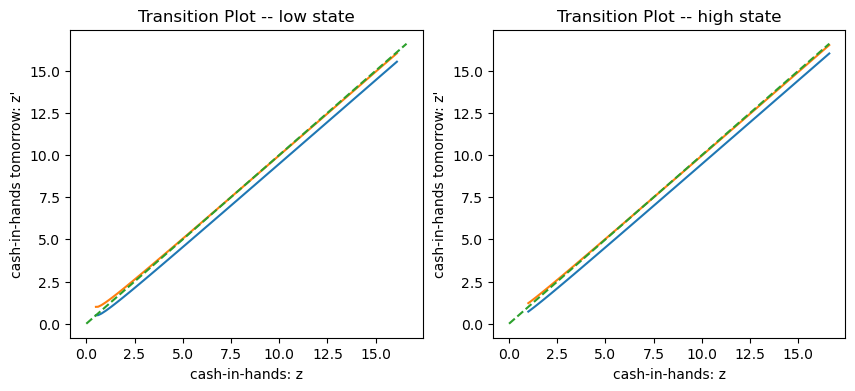

In [5]:
plt.figure(figsize=(10, 4))
for plot_i, label in ((0, 'low'), (1, 'high')):
    plt.subplot(121 + plot_i)
    plt.title("Transition Plot -- " + label + " state")
    state = plot_i
    zmax = bigR * ahat_max + max(y_g)
    for s in range(n):
        plt.plot(
            [bigR * ahat_g[i] + ytilde_g[state] for i in range(grid_points)],
            [bigR * ahat_g[policy[i, state]] + ytilde_g[s] for i in range(grid_points)])
    plt.plot((0, zmax), (0, zmax), '--')
    plt.ylabel("cash-in-hands tomorrow: z'")
    plt.xlabel("cash-in-hands: z")

## The stationary distribution 

The following function takes an initial pdf and iterates using the policy function to obtain the stationary distribution 

In [6]:
@nb.jit
def get_stationary_distribution(pdf_0, policy, tolerance=10**(-7)):
    while True:
        pdf_1 = np.zeros((grid_points, n))
        for i in range(grid_points):
            for s in range(n):
                for sprime in range(n):
                    pdf_1[policy[i, s], sprime] += p[s, sprime] * pdf_0[i, s]
        distance = 0.0
        for i in range(grid_points):
            for s in range(n):
                distance = max(abs(pdf_1[i, s] - pdf_0[i, s]), distance)
        if distance - tolerance < 0:
            break
        else:
            pdf_0 = pdf_1
    return pdf_1

### Computing the stationary distribution

In [7]:
pdf_0 = np.ones((grid_points, n)) / (grid_points * n)
t = time.time()
pdf_ss = get_stationary_distribution(pdf_0, policy)
print(' {} seconds'.format(time.time() - t))

 0.17412781715393066 seconds


### Plotting the Stationary distribution over assets

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
C:\Users\30945\AppData\Local\Temp\ipykernel_20044\3203176394.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('$\hat{a}$', fontsize=16)
C:\Users\30945\AppData\Local\Temp\ipykernel_20044\3203176394.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('$\hat{a}$', fontsize=16)


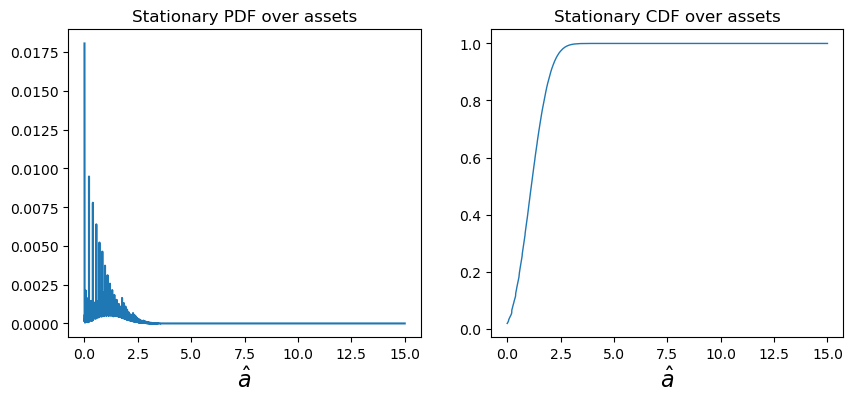

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
pdf_assets = np.zeros((grid_points)) 
for i in range(grid_points):
        pdf_assets[i] = np.sum(pdf_ss[i, :])
plt.plot(ahat_g, pdf_assets)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary PDF over assets');

plt.subplot(122)
plt.plot(ahat_g, np.cumsum(pdf_assets), lw = 1)
plt.xlabel('$\hat{a}$', fontsize=16)
plt.title('Stationary CDF over assets');